<a href="https://colab.research.google.com/github/anh1811/YOLO/blob/main/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
from IPython.display import Image, clear_output  # to display images
import torchvision
import pickle as pkl
import numpy as np
import os
import cv2
from torchvision import transforms
import xml.etree.ElementTree as ET
import pickle
from os import listdir, getcwd
from os.path import join
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Using torch 1.9.0+cu102 (Tesla K80)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset/Dataloader**

In [ ]:
# # #Load the VOC dataset
%cd /content/
!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
# let's just load it in content

!tar xf /content/VOCtrainval_11-May-2012.tar
!tar xf /content/VOCtrainval_06-Nov-2007.tar
!tar xf /content/VOCtest_06-Nov-2007.tar

/content
--2021-09-17 07:40:16--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  22.7MB/s    in 84s     

2021-09-17 07:41:41 (22.7 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2021-09-17 07:41:41--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  22.9MB/s    in 20s     

2021-09-17 07:42:02

In [ ]:
#transform the dataset
# this code is stolen from YOLO:Darknet pjreddie.com
sets=[('2012', 'train'), ('2012', 'val'), ('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert(size, box):
#transform into the defaut gt box for YOLO
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(year, image_id):
# write file labels
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    out_file = open('VOCdevkit/VOC%s/labels/%s.txt'%(year, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for year, image_set in sets:
    if not os.path.exists('VOCdevkit/VOC%s/labels/'%(year)):
        os.makedirs('VOCdevkit/VOC%s/labels/'%(year))
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg\n'%(wd, year, image_id))
        convert_annotation(year, image_id)
    list_file.close()

In [ ]:
%cd /content/
!cat 2007_train.txt > train.txt
!cat 2007_val.txt > val.txt

/content


In [ ]:
#create data loader, dataset
class DataSet(torch.utils.data.Dataset):
  """
  Dataset use for yolo training
  """
  def __init__(self, path_img, path_txt, transform):
    """
    Args:
      path_img (string): path which write all the path to each file image
      path_txt (string): dir which contain all the file of index of gt box
      transform (class): transfrom image 
    """
    self.list_img = []
    with open(path_img, 'r') as file:
      self.list_img = [line.strip() for line in file]
    self.transform = transform
    self.path_img = path_img
    self.path_txt = path_txt
  
  def __getitem__(self, i):
    """
    Args:
      index i
    Return:
      image (tensor): size(3,448,448)
      box (tensor): size(nobj, 5) 5 = [id_cls, x_cen, y_cen, width, height]
    """
    # test if the index is an int for slice:
    assert isinstance(i, int)
    
    #get the img path and their groudth truth box coordinate
    img_path = self.list_img[i]
    split_img_path = img_path.split('/')
    box_path = split_img_path[-1][:-4] + '.txt'
    year = split_img_path[-3]
    
    #read the image
    img = cv2.imread(img_path)
    #read the box
    path = os.path.join(self.path_txt, year + '/labels')
    with open(os.path.join(path, box_path), 'r') as file:
      # list of all the boxes in one image
      boxes = []
      for line in file.readlines():
        box = [float(a) for a in line.split(' ')] #the coordinate of the box 
        boxes.append(box)
    boxes = np.array(boxes) 

    sample = [img, boxes]
    #transform
    if self.transform:
      sample = self.transform(sample)

    return sample[0].float(), sample[1].float()
  
  def __len__(self):
    """
    Return:
      len(dataset)
    """
    return len(self.list_img)

In [ ]:
class Padding(object):
    """
      Padding image into the shape require of the model
    """
    def __init__(self, inp_dim):
        """
          ind_dim (int): required size of the image
        """
        assert isinstance(inp_dim, int)
        self.inp_dim = inp_dim
        
    def __call__(self, sample):
        """
          sample (list): image, box
        """
        img, boxes = sample[0], sample[1]
        w, h = img.shape[1], img.shape[0]
        scale = min(self.inp_dim/w, self.inp_dim/h)
        
        # one of this axis will have the same length as the inp_dim
        w_new = int(w * scale)
        h_new = int(h * scale)
        img = cv2.resize(img, (w_new, h_new))

        #create a image that is pixel =  128
        image = np.full((self.inp_dim, self.inp_dim, 3), 128.)
        #paste the img into the middle
        image[(self.inp_dim - h_new)//2:(self.inp_dim - h_new)//2 + h_new, 
              (self.inp_dim - w_new)//2:(self.inp_dim - w_new)//2 + w_new,  :] = img        
        
        if boxes.shape[0] == 0:
          return image, boxes
        
        #bring the box to the original dimensional
        boxes[:,[1,3]] *= w
        boxes[:,[2,4]] *= h

        #rescale the box
        boxes[:, 1:] *= scale
        boxes[:, 1] += (self.inp_dim - w_new)//2
        boxes[:, 2] += (self.inp_dim - h_new)//2

        #rescale back the image
        boxes[:, [1,3]] /= self.inp_dim
        boxes[:, [2,4]] /= self.inp_dim
        return image, boxes

class Resize(object):
  def __init__(self, inp_dim = 448):
    assert isinstance(inp_dim, int)
    self.inp_dim = inp_dim
  
  def __call__(self, sample):
    """
        sample (list): image, box
    """
    img, boxes = sample[0], sample[1]
    img = cv2.resize(img, (self.inp_dim, self.inp_dim))
    return img, boxes

class ToTensor(object):
    def __call__(self, sample):
      to_tensor = transforms.ToTensor()
      image, rec = sample[0], sample[1]
      return to_tensor(image), to_tensor(rec)


class Normalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
  
  def __call__(self, sample):
   normalize = transforms.Normalize(mean = self.mean, std = self.std)
   return normalize(sample[0]), sample[1]

class RandomBlur():
  def __init__(self, kernel_size, sigma = [.1, 2.0]):
    self.kernel_size = kernel_size
    self.sigma = sigma
  
  def __call__(self, sample):
   blur = transforms.GaussianBlur(kernel_size= self.kernel_size, sigma = self.sigma)
   return blur(sample[0]), sample[1]

class ColorChange():
  def __init__(self, bright = .5, satur = .75, hue = .1, contrast = 0):
    self.bright = bright
    self.sat = satur
    self.hue = hue
    self.contrast = contrast
  def __call__(self, sample):
    color = transforms.ColorJitter(brightness = self.bright, contrast = self.contrast, 
                                   saturation = self.sat, hue = self.hue)
    return color(sample[0]), sample[1]

class HorizonFlip():
  def __init__(self, percent = .5):
    self.per = percent
  def __call__(self, sample):
    if torch.rand(1) < self.per:
      img = cv2.flip(sample[0], 1)
      sample[1][:,1] = 1 - sample[1][:,1]
      return img, sample[1]
    else:
      return sample
  
class RandomScaling():
  def __init__(self, per = 0.5):
    self.per = per
  def __call__(self, sample):
    if torch.rand(1) < 0.5:
      #get img size
      im, boxes = sample[0], sample[1]
      h, w, c = im.shape
      scale = np.random.uniform()/5. + 1.

      im = cv2.resize(im, dsize=(int(w * scale), h), interpolation=cv2.INTER_LINEAR)
      return im, boxes
    else:
      return sample


class RandomTranslation():
  def __init__(self, per = 0.5):
    self.per = per
  def __call__(self, sample):
    if torch.rand(1) < 0.5:
      #get img size
      im, boxes = sample[0], sample[1]
      h, w, c = im.shape
      scale = np.random.uniform()/2.  + 1.
      
      max_offx = (scale-1.) * w
      max_offy = (scale-1.) * h
      offx = int(np.random.uniform() * max_offx)
      offy = int(np.random.uniform() * max_offy)

      im = cv2.resize(im, (0,0), fx = scale, fy = scale)
      boxes[:,[1,3]] *= (scale * w)
      boxes[:,[2,4]] *= (scale * h)
      
      im = im[offy : (offy + h), offx : (offx + w)]
      boxes[:,[1,2]] -= np.array([offx, offy])
      num_obj = boxes.shape[0]

      boxes_xyxy = boxes.copy()
      boxes_xyxy[:,[1,2]] = boxes[:,[1,2]] - boxes[:,[3,4]]/2.
      boxes_xyxy[:,[3,4]] = boxes[:,[1,2]] + boxes[:,[3,4]]/2.

      x1 = boxes_xyxy[:,1]   
      y1 = boxes_xyxy[:,2]  
      x2 = boxes_xyxy[:,3]  
      y2 = boxes_xyxy[:,4]  

      np.clip(x1, a_min = 0, a_max = None, out = x1)
      np.clip(y1, a_min = 0, a_max = None, out = y1)
      np.clip(x2, a_min = None, a_max = w, out = x2)
      np.clip(y2, a_min = None, a_max = h, out = y2)

      filter1 = np.where((x2 > x1) & (x2 >= 25))
      filter2 = np.where((y2 > y1) & (y2 >= 25))
      filter = np.intersect1d(filter1[0], filter2[0])
      boxes_xyxy = boxes_xyxy[filter]

      boxes = boxes_xyxy.copy()
      boxes[:,[1,2]] = (boxes_xyxy[:, [1,2]] + boxes_xyxy[:,[3,4]]) / 2.
      boxes[:,[3,4]] = (boxes_xyxy[:, [3,4]] - boxes_xyxy[:,[1,2]])

      boxes[:, [1,3]] /= w
      boxes[:, [2,4]] /= h
      return im, boxes
    else:
      return sample

In [ ]:
basic_transform = transforms.Compose([Resize(), 
                                      ToTensor()])
augment = transforms.Compose([RandomScaling(), RandomTranslation(), Resize(), HorizonFlip(),
                              ToTensor(), ColorChange(), RandomBlur(kernel_size = 3)])
# augment = transforms.Compose([RandomTranslation(), ToTensor(), Normalize(mean = 0, std = 255.)])
path_img = '/content/train.txt'
path_label = '/content/VOCdevkit'
path_img_val = '/content/val.txt'

dataset = DataSet(path_img=path_img, path_txt= path_label, transform = augment)
valdataset = DataSet(path_img= path_img_val, path_txt= path_label, transform=basic_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 5])


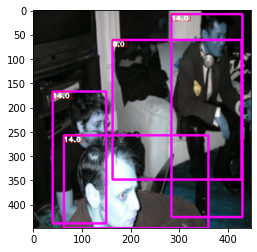

In [ ]:
from google.colab.patches import cv2_imshow
#test
test = dataset[20]
img = test[0].cpu().numpy()
img = np.ascontiguousarray(np.transpose(img, (1,2,0))) 
img_attri = test[1].squeeze(0)
print(img_attri.size())
for i in range(img_attri.size(0)):
  attri = img_attri[i]
  label = "{0}".format(attri[0])
  box = attri[1:]
  box *= 448
  box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
  box = box.numpy()
  xmin ,ymin, xmax, ymax = box
  #bug issues: rectangle return Umat type if np.array is not contiguous 
  img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,255), 3)
  t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
  img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
                                ,(255,0,0), 1)
  img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
                              cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 2)
plt.imshow(img)

In [ ]:
def my_collate(batch):
    tensor_image = batch[0][0]
    for image,_ in batch[1:]:
      tensor_image = torch.cat((tensor_image,image), 0)
    rectangle = [item[1] for item in batch]
    tensor_image = tensor_image.view(-1,3,448,448).contiguous()
    return [tensor_image, rectangle]

train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           collate_fn=my_collate,
                                            batch_size=32,
                                           num_workers = 2,
                                           shuffle=True,
                                          pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=valdataset,
                                         collate_fn=my_collate,
                                         batch_size=32,
                                         num_workers = 2,
                                         pin_memory=True)

In [ ]:
#test
data_iter = iter(train_loader)
frame = next(data_iter)

# **Model**

In [ ]:
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov1-tiny.cfg
# %cd /content/drive/MyDrive/Data/yolov1/
# # %mkdir cfg

# creat model
folder_dir = '/content/drive/MyDrive/Data/yolov1' 
os.makedirs('/content/drive/MyDrive/Data/yolov1', exist_ok=True)
%cd /content/drive/MyDrive/Data/yolov1/cfg/

/content/drive/MyDrive/Data/yolov1/cfg


In [ ]:
def parsefile(file):
    '''
      Change file config into a list of dictionary
      Arg:
          File: (string) file config
      Return:
          List of dictionary
    '''
    config = open(file, 'r')
    lines = config.read().split('\n')
    lines = [x for x in lines if len(x) != 0] #remove blank line
    lines = [x for x in lines if x[0] != '#'] #remove comment 
    lines = [x.strip() for x in lines]  #remove whitespace
    
    block = {}
    blocks = []

    for line in lines:
        # start of a dict
        if line[0] == '[':
            # if it has already had a box
            if len(block) != 0:
                #add the previous dict into list
                blocks.append(block)
                block = {}
            # the first index of a dict will always be its type
            block['type'] = line[1:-1].rstrip()
        else:
            # get the other value into the dict
            key, value = line.split('=')
            block[key.rstrip()] = value.lstrip()
    # the last dict
    blocks.append(block)
    return blocks      

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    '''
    Print out a table of parameters that the model has to store
    Arg:
        model: (object) the model that we want to know tha parameters
    Return:
        table of parameters and their weight
    '''
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# FastYolo model


In [ ]:
def building_fast_yolo(blocks):
    '''
      Building model (fastyolo) from blocks

      Args:
          blocks: (list) list of dictionary which contain each modules respectively
      Return:
          net_info: (dictionary) contains all the info about the model and hyperparameters
          list_module (ModuleList) module list of all the modules in the model 
    '''
    
    #model info
    net_info = blocks[0]
    list_module = nn.ModuleList()
    input_size = 3
    output_filters = []
    for i, block in enumerate(blocks[1:]):
        module = nn.Sequential() #convol module can have a lot of layer
        
        #convolutional layer
        if block['type'] == 'convolutional':
            # is there batch_normalize 
            try:
                batch_normalize = int(block['batch_normalize'])
                bias = False
            except:
                batch_normalize = 0
                bias = True
            
            # arguments for conv2d
            output_size = int(block['filters'])
            kernel_size = int(block['size'])
            stride = int(block['stride'])
            pad = int(block['pad'])

            if pad:
                padding = (kernel_size - 1) // 2
            else:
                padding = 0
            conv = nn.Conv2d(input_size, output_size, kernel_size = kernel_size, stride = stride, padding = padding,
                            bias = bias)
            module.add_module('conv_{}'.format(i), conv)
            
            #perform batch_normalize
            if batch_normalize:
                batchnorm = nn.BatchNorm2d(output_size)
                module.add_module('batchnorm_{}'.format(i), batchnorm)
            
            #perform activation function
            activation_func = block['activation']
            if activation_func == 'leaky':
                leaky = nn.LeakyReLU(0.1, inplace = True)
                module.add_module('leaky_{}'.format(i), leaky)
        
        #maxpool
        elif block['type'] == 'maxpool':
            stride = int(block['stride'])
            size = int(block['size'])
            maxpool = nn.MaxPool2d(size, stride=stride)
            module.add_module('maxpool_{}'.format(i), maxpool)
        
        #connected
        elif block['type'] == 'connected':
          output_size = int(block['output'])
          flatten = nn.Flatten()
          module.add_module('flatten_{}'.format(i), flatten)
          input_size *= 49
          activation_func = block['activation']
          fc = nn.Linear(input_size, output_size)
          module.add_module('fc_{}'.format(i), fc)
        
        elif block['type'] == 'detection':
            detection = nn.Sigmoid()
            module.add_module("Detection_{}".format(i), detection)
        
        output_filters.append(output_size)
        list_module.append(module)
        input_size = output_size
    return (net_info, list_module)


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

In [ ]:
class Darknetbase(nn.Module):
  def __init__(self, file, use_fc = False):
    '''
      Building backbone models for fast yolo

      Args:
          file: (string) file config
          use_fc: (bool) if use the fc layer ?
    '''
    super(Darknetbase, self).__init__()
    self.blocks = parsefile(file)
    self.features = building_fast_yolo(self.blocks)[1][:-2]
    self.use_fc = use_fc
    if use_fc:
      self.fc = self.features.append(
          nn.Sequential(
              nn.AvgPool2d(7),
              nn.Conv2d(1024, 1000, 1, 1, padding = 0),
              nn.Softmax2d()
          )
      )  

  def forward(self, x):
    for module in self.features:
      x = module(x)
    if self.use_fc:
      x = self.fc(x)
  
  def _initialize_weights(self):
        for m in self.features:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
  
  #load pretrain_weight
    #TODO

In [ ]:
# # !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/darknet.cfg
# # !wget http://pjreddie.com/media/files/darknet.conv.weights
# Darknet = Darknetbase('yolov1-tiny.1.cfg', use_fc = False)
# count_parameters(Darknet)
# # Darknet.features
# # Darknet.load_weight('darknet.weights')
  

In [ ]:
class YOLOV1tiny(nn.Module):
  def __init__(self, file, features):
      '''
        Building fastyolo model

        Args:
          file: (string) file config
          features: (object) use the parameters in the darknetbone
      '''
      super(YOLOV1tiny, self).__init__()
      self.blocks = parsefile(file)
      self.net_info, self.module_list = building_fast_yolo(self.blocks)
      self.inp_dims = int(self.net_info['height'])
      detection_layer = self.blocks[-1]
      self.grid_size = int(detection_layer['side'])
      self.num_classes = int(detection_layer['classes'])
      self.num_box = int(detection_layer['num'])
      if features:
        for i, module in enumerate(features):
          self.module_list[i] = module
      self.float().to(device)
  
  def forward(self, x):
    
    x = x.to(device)
    for i, module in enumerate(self.blocks[1:]):
      module_type = module['type']
      x = self.module_list[i](x)
      if module_type == 'detection':
        batch_size = x.size(0)
        detection = x.view(batch_size, self.num_box * 5 + self.num_classes, self.grid_size, self.grid_size)
    return detection

In [ ]:
# model = YOLOV1tiny('yolov1-tiny.1.cfg', Darknet.features)
# count_parameters(model)

# Old yolov1

In [ ]:
def building_model(blocks):
    '''
      Building model (yolov1) from blocks

      Args:
          blocks: (list) list of dictionary which contain each modules respectively
      Return:
          net_info: (dictionary) contains all the info about the model and hyperparameters
          list_module (ModuleList) module list of all the modules in the model 
    '''
    
    #model info
    net_info = blocks[0]
    list_module = nn.ModuleList()
    input_size = 3
    
    #check if the first connected layer
    is_the_first_connected = True
    output_filters = []
    for i, block in enumerate(blocks[1:]):
        module = nn.Sequential() #convol module can have a lot of layer
        
        #convolutional layer
        if block['type'] == 'convolutional':
            # is there batch_normalize 
            try:
                batch_normalize = int(block['batch_normalize'])
                bias = False
            except:
                batch_normalize = 0
                bias = True
            
            # arguments for conv2d
            output_size = int(block['filters'])
            kernel_size = int(block['size'])
            stride = int(block['stride'])
            pad = int(block['pad'])

            if pad:
                padding = (kernel_size - 1) // 2
            else:
                padding = 0
            conv = nn.Conv2d(input_size, output_size, kernel_size = kernel_size, stride = stride, padding = padding,
                            bias = bias)
            module.add_module('conv_{}'.format(i), conv)
            
            #perform batch_normalize
            if batch_normalize:
                batchnorm = nn.BatchNorm2d(output_size)
                module.add_module('batchnorm_{}'.format(i), batchnorm)
            
            #perform activation function
            activation_func = block['activation']
            if activation_func == 'leaky':
                leaky = nn.LeakyReLU(0.1, inplace = True)
                module.add_module('leaky_{}'.format(i), leaky)
        
        #maxpool
        elif block['type'] == 'maxpool':
            stride = int(block['stride'])
            size = int(block['size'])
            maxpool = nn.MaxPool2d(size, stride=stride)
            module.add_module('maxpool_{}'.format(i), maxpool)
        
        
        #dropout
        elif block['type'] == 'dropout':
            prob = float(block['probability'])
            dropout = nn.Dropout2d(prob)
            module.add_module('dropout_{}'.format(i), dropout)
        
        elif block['type'] == 'avgpool':
          avgpool = nn.AvgPool2d(7)
          module.add_module('avgpool_{}'.format(i), avgpool)

        elif block['type'] == 'softmax':
          softmax = nn.Softmax2d()
          module.add_module('softmax_{}'.format(i), softmax)

        #connected
        elif block['type'] == 'connected':
          output_size = int(block['output'])
          
          if is_the_first_connected:
            flatten = nn.Flatten()
            module.add_module('flatten_{}'.format(i), flatten)
            input_size *= 49
            is_the_first_connected = False
          
          activation_func = block['activation']
          fc = nn.Linear(input_size, output_size)
          module.add_module('fc_{}'.format(i), fc)
          if activation_func == 'leaky':
            leaky = nn.LeakyReLU(0.1, inplace = True)
            module.add_module('leaky_{}'.format(i), leaky)
        
        elif block['type'] == 'detection':
            detection = nn.Sigmoid()
            module.add_module("Detection_{}".format(i), detection)
        
        output_filters.append(output_size)
        list_module.append(module)
        input_size = output_size
    return (net_info, list_module)

Some function for the load_weight

In [ ]:
def load_conv_bn(buf, start, conv_model, bn_model):
    """
    load the convolutional weight with batch normalisation
    Args:
      buf (nparray): contain all the weight
      start (int): a pointer to indicate where we are in the weight array
      conv_model (model): convolutional layer
      bn_model (model): batch_normalisation model
    Return:
      start (int): to indicate where we are now in the weight file
    """
    num_w = conv_model.weight.numel() #weight len for the conv_model
    num_b = bn_model.bias.numel() #bias (weight) len for the batch_nor model
    
    #load weight for the batchnormalise layer
    bn_model.bias.data.copy_(torch.from_numpy(buf[start:start + num_b]));
    start = start + num_b #change to next weight
    bn_model.weight.data.copy_(torch.from_numpy(buf[start:start + num_b]));
    start = start + num_b
    bn_model.running_mean.copy_(torch.from_numpy(buf[start:start + num_b]));
    start = start + num_b
    bn_model.running_var.copy_(torch.from_numpy(buf[start:start + num_b]));
    start = start + num_b
    
    #load weight for the convolutional layer
    conv_model.weight.data.copy_(torch.from_numpy(buf[start:start + num_w]).reshape(conv_model.weight.data.shape));
    start = start + num_w
    return start

def load_conv(buf, start, conv_model):
    """
    load the convolutional weight without batch normalisation
    Args:
      buf (nparray): contain all the weight
      start (int): a pointer to indicate where we are in the weight array
      conv_model (model): convolutional layer
    """
    #weight len of the convolutional layer
    num_w = conv_model.weight.numel()
    #bias len of the convolutional layer
    num_b = conv_model.bias.numel()
    conv_model.bias.data.copy_(torch.from_numpy(buf[start:start + num_b]));
    start = start + num_b #change to next weight
    conv_model.weight.data.copy_(torch.from_numpy(buf[start:start + num_w]).reshape(conv_model.weight.data.shape));
    start = start + num_w
    return start

def load_fc(buf, start, fc_model):
  """
    Load the fully_connected weight
    Args:
      buf (nparray): contain all the weight
      start (int): a pointer to indicate where we are in the weight array
      fc_model (model): fully connected layer
  """  
  num_w = fc_model.weight.numel()
  num_b = fc_model.bias.numel()
  fc_model.bias.data.copy_(torch.from_numpy(buf[start:start + num_b]));
  start = start + num_b
  fc_model.weight.data.copy_(torch.from_numpy(buf[start:start + num_w]).reshape(fc_model.weight.data.shape));
  start = start + num_w
  return start

In [ ]:
class Extraction(nn.Module):
  def __init__(self, file):
    """ Backbone for the yolov1
      Args:
          blocks: (list) config list of module
          models: (list) model_info and modules built in model
      """
    super(Extraction, self).__init__()
    self.blocks = parsefile(file)
    self.models = building_model(self.blocks)[1]

  def forward(self, x):
    for module in self.features:
      x = module(x)
  
  def _initialize_weights(self):
        for m in self.features:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

  def load_weights(self, weightfile):
        fp = open(weightfile, 'rb')
        header = np.fromfile(fp, count=4, dtype=np.int32)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        buf = np.fromfile(fp, dtype=np.float32)
        fp.close()

        start = 0
        ind = -2
        is_the_first_connected = True
        for block in self.blocks:
            if start >= buf.size:
                break
            ind = ind + 1
            if block['type'] == 'net':
                continue
            elif block['type'] == 'convolutional':
                model = self.models[ind]
                try:
                  batch_normalize = int(block['batch_normalize'])
                except:
                  batch_normalize = 0
                if batch_normalize:
                    start = load_conv_bn(buf, start, model[0], model[1])
                else:
                    start = load_conv(buf, start, model[0])
            elif block['type'] == 'connected':
                model = self.models[ind]
                if is_the_first_connected:
                    start = load_fc(buf, start, model[1])
                    is_the_first_connected = False
                else:
                    start = load_fc(buf, start, model[0])
            elif block['type'] == 'maxpool':
                pass
            elif block['type'] == 'reorg':
                pass
            elif block['type'] == 'upsample':
                pass
            elif block['type'] == 'route':
                pass
            elif block['type'] == 'shortcut':
                pass
            elif block['type'] == 'region':
                pass
            elif block['type'] == 'yolo':
                pass
            elif block['type'] == 'avgpool':
                pass
            elif block['type'] == 'softmax':
                pass
            elif block['type'] == 'cost':
                pass
            else:
                print('unknown type %s' % (block['type']))
    

In [ ]:
class YOLOV1(nn.Module):
  def __init__(self, file, features):
      '''
        Building yolo model

        Args:
            file: (string) file config
            features: (object) use the parameters in the backbone
      '''
      super(YOLOV1, self).__init__()
      self.blocks = parsefile(file)
      self.net_info, self.module_list = building_model(self.blocks)
      self.inp_dims = int(self.net_info['height'])
      detection_layer = self.blocks[-1]
      self.grid_size = int(detection_layer['side'])
      self.num_classes = int(detection_layer['classes'])
      self.num_box = int(detection_layer['num'])
      
      for m in self.module_list:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
      
      if features:
        for i, module in enumerate(features):
          self.module_list[i] = module 
      self.float().to(device)
  
  def forward(self, x):
    """
      Args:
        x (tensor): size(Batch, 3 , inp_dims(448), inp_dims(448))
      Return
        detection (tensor): size(Batch, num_box * 5 + num_classes, grid, grid) 
    """
    for i, module in enumerate(self.blocks[1:]):
      module_type = module['type']
      x = self.module_list[i](x)
      if module_type == 'detection':
        batch_size = x.size(0)
        detection = x.view(batch_size, self.num_box * 5 + self.num_classes, self.grid_size, self.grid_size)
    return detection
  
  def _initialize_weights(self):
        for m in self.features:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
extraction = Extraction('extraction.cfg')
extraction.load_weights('extraction.weights')
model = YOLOV1('yolov1-tiny.cfg', features=extraction.models[:-3])

In [ ]:
test = dataset[0]
model = model.to(device)
pre = model(test[0].unsqueeze(0).to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# **Loss**

In [ ]:
class Loss(nn.Module):

  def __init__(self, inp_dims = 448, grid_size = 7, num_classes = 20, num_box = 2, lambda_coord=5.0, lambda_noobj=0.5):
      """ Constructor.
      Args:
          inp_dims: (int) size of image
          grid_size: (int) size of input feature map.
          num_box: (int) number of bboxes per each cell.
          num_classes: (int) number of the object classes.
          lambda_coord: (float) weight for bbox location/size losses.
          lambda_noobj: (float) weight for no-objectness loss.
      """
      super(Loss, self).__init__()

      self.grid = grid_size
      self.box = num_box
      self.cls = num_classes
      self.lambda_coord = lambda_coord
      self.lambda_noobj = lambda_noobj
      self.mse = nn.MSELoss(reduction = 'sum')
  
  def forward(self, prediction, target):
    """
    loss_functionv1 use only the prediction in each grid cell of the image, 
    for each grid cell there can only one object with one class
    Args:
      prediction (tensor): size(Batch, 5*num_box + num_classes, grid_size, grid_size)
      target (list): elements: tensor , size(5)
    Return:
      loss (float)
    """

    batch_size = prediction.size()[0]
    #transform into (batchx(grid^2x)x(nm_classes + 5 *numbox)
    prediction = prediction.view(batch_size, -1, self.grid * self.grid)
    prediction = prediction.transpose(2,1).contiguous() #size(bx49x30)

    os_not_created = True 
    cls_not_created = True
    box_not_created = True
    nos_not_created = True

    for i in range(batch_size):
      #prediction for one image
      pre = prediction[i] #size(49,30)
      
      if target[i].size(1) == 0:
        
        os_box_nobj = pre[:,[4,9]].view(-1,1)
        if nos_not_created:
          nos_pre = os_box_nobj
          nos_not_created = False
        else:
          nos_pre = torch.cat((nos_pre, os_box_nobj), 0)
        continue
      # this label for the img
      tar = target[i].squeeze(0).to(device) #size(num_obj,5)
      num_obj = tar.size(0)

      # one hot encoding
      I = torch.eye(self.cls)
      class_index = I[tar[:,0].type(torch.long)].to(device) #size(num_obj,20)
      tar = torch.cat((tar[:,1:], class_index), 1) #size(num_obj, 24)

      # index of all the grid that has obj
      index = (tar[:,0]*self.grid).type(torch.long) + self.grid * (tar[:,1]*self.grid).type(torch.long)

      #transform target cx, cy from relative to image size to relative to cell-size 
      for i in range(len(index)):
        x_box = index[i] % 7 #row
        y_box = index[i] // 7 #col
        tar[i, 0]  = tar[i, 0] * 7 - x_box
        tar[i, 1] = tar[i, 1] * 7 - y_box

      # a filter to indicate which grid is resposible
      filter = torch.ones(self.grid * self.grid)
      
      # grid that has object
      res_grid = pre[index] #size(num_obj,30)

      #grouth truth box for iou
      gt_box = tar[:,:4] #size(num_obj, 4)
      gt_box_xy = Variable(torch.FloatTensor(gt_box.size())).to(device)
      # transform from cell-relative to image-relative (hệ tọa độ ở góc trên bên trái)
      gt_box_xy[:,:2] = tar[:,:2]/float(self.grid) - 0.5 * tar[:, 2:4]
      gt_box_xy[:,2:4] = tar[:,:2]/float(self.grid) + 0.5 * tar[:, 2:4]
      
      for i in range(num_obj):
        # if there is a more than one object in this grid skip the behind
        if filter[index[i]]:
          filter[index[i]] = 0
        else:
          continue

        # class loss for each grid
        grid_cls = res_grid[i, 10:].unsqueeze(0)
        tar_cls = tar[i, 4:].unsqueeze(0)

        # create a tensor of class_pre and class_tar
        if cls_not_created:
          class_tar = tar_cls #size(1,20)
          class_pre = grid_cls #size(1,20)
          cls_not_created = False
        else:
          class_tar = torch.cat((class_tar, tar_cls), 0)
          class_pre = torch.cat((class_pre, grid_cls), 0)

        # find the box resposible
        pre_box = res_grid[i, :10].view(-1,5) #size(2,5)
        pre_box_xy = Variable(torch.FloatTensor(pre_box[:,:4].size())).to(device)
        #change to relative to image size
        pre_box_xy[:,  :2] = pre_box[:, :2]/float(self.grid) - 0.5 * pre_box[:, 2:4]
        pre_box_xy[:, 2:4] = pre_box[:, :2]/float(self.grid) + 0.5 * pre_box[:, 2:4]
        
        # iou
        box_iou = torchvision.ops.box_iou(pre_box_xy, gt_box_xy[i].unsqueeze(0)) #size(num_box, 1) 
  
        # value and indice of the box with the highest iou
        # the iou is the confidence score target
        os, index_obj = torch.max(box_iou, 0) #1,1
        res_box = pre_box[index_obj] #size(1,5)

        #tensor for box resposible confidence
        if os_not_created:
          os_tar = os.type(torch.float)
          os_pre = res_box[:,4]
          os_not_created = False
        else:
          os_tar = torch.cat((os_tar, os.type(torch.float)), 0)
          os_pre = torch.cat((os_pre, res_box[:,4]), 0)

        #tensor for coordinate
        if box_not_created:
          box_res = res_box[:,:4]
          box_tar = gt_box[i,:4].unsqueeze(0)
          box_not_created = False
        else:
          box_res = torch.cat((box_res, res_box[:,:4]),0)
          box_tar = torch.cat((box_tar, gt_box[i,:4].unsqueeze(0)),0)

        #loss with box no object
        index_bnobj = (torch.arange(self.box) != index_obj.cpu()).nonzero(as_tuple=True)[0]
        os_box_nobj = pre_box[index_bnobj, 4].unsqueeze(0) #size(1,1)
        if nos_not_created:
          nos_pre = os_box_nobj
          nos_not_created = False
        else:
          nos_pre = torch.cat((nos_pre, os_box_nobj), 0)

      #grid with no object only have objective loss
      filter = filter.nonzero().squeeze(1)
      grid_nobj = pre[filter] #size(num_obj, 30)
      os_grid_nobj = grid_nobj[:,[4,9]].view(-1,1) #size(num_obj * 2, 1)
      nos_pre = torch.cat((nos_pre, os_grid_nobj), 0)

    lnobj = self.mse(nos_pre, torch.zeros((nos_pre.size())).to(device))
    lbox = self.mse(box_res[:,:2], box_tar[:,:2]) + self.mse(torch.sqrt(box_res[:,2:4]),torch.sqrt(box_tar[:,2:4]))
    lobj = self.mse(os_pre, os_tar)
    lclas = self.mse(class_pre, class_tar)
    # print(lobj)
    # print(lclas)
    # print(lnobj)
    # print(lbox)
    loss = self.lambda_coord*lbox + lobj + self.lambda_noobj * lnobj + lclas
    return loss.float()

# **Train**

In [ ]:
os.makedirs('SGD2',exist_ok=True)
os.makedirs('pretrain', exist_ok=True)
os.makedirs('Adam', exist_ok = True)
os.makedirs('SGD_19/8', exist_ok = True)
os.makedirs('train_final',exist_ok=True)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/content/drive/MyDrive/Data/yolov1/cfg/train2')

In [ ]:
# Darknet = Darknetbase('yolov1-tiny.1.cfg', use_fc = False)
# Darknet._initialize_weights()
# model = YOLOV1tiny('yolov1-tiny.1.cfg', Darknet.features)
extraction = Extraction('extraction.cfg')
extraction.load_weights('extraction.weights')
model = YOLOV1('yolov1-tiny.cfg', features=extraction.models[:-3]).to(device)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

#get grid_size, num_box, num_classes
grid_size = model.grid_size
num_box = model.num_box
num_classes = model.num_classes
inp_dims = model.inp_dims
# optimizer = torch.optim.Adam(model.parameters(), lr =0.001, weight_decay = 0.0005, amsgrad=True)
gamma=10**(1./16.)

len_dataset = len(dataset)
len_valdataset = len(valdataset)
torch.backends.cudnn.benchmark = True

In [ ]:
# #pretrain
# index = 0
# model.train()
# for epoch in range(20):
#   loss_epoch = 0
#   for i, (image, label) in enumerate(train_loader):
  
#     image = Variable(image)
#     pre = model(image)
#     loss = criterion(pre, label)
#     loss_epoch += loss

#     # Backward and optimize
#     optimizer.zero_grad()
#     loss.backward()
#     # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2, error_if_nonfinite=True)
#     optimizer.step()
#   print('Epoch[{}]: {:.7f}'.format(epoch, loss_epoch/len_dataset))

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'loss': loss_epoch/len_dataset,
#     }, '/content/model.weight{}'.format(index))

In [ ]:
# import time
# #load_pretrain
# checkpoint = torch.load('pretrain/model.weight0', map_location = 'cpu')
# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3, momentum=0.9, weight_decay=0.0005)
# scheduler_epoch = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,105,135], gamma=0.1)
# criterion = Loss()
# epoches = 135
# best_val_loss = 100
# for epoch in range(epoches):
#   start_time = time.time()
#   train_loss = 0
#   val_loss = 0
#   model.train()
#   for i, (image, label) in enumerate(train_loader):
#     image = Variable(image).to(device)
#     label = label
#     pre = model(image)
#     loss = criterion(pre, label)
#     train_loss += loss.item()

#     # Backward and optimize
#     optimizer.zero_grad()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2, error_if_nonfinite=False)
#     optimizer.step()
    
#     if epoch == 0 and i%5 == 0:
#       for g in optimizer.param_groups:
#         g['lr'] *= gamma
  
#   model.eval()
#   with torch.no_grad():
#     for images, labels in val_loader:
#       images = images.to(device)
        
#       # Forward pass
#       outputs = model(images)
#       loss = criterion(outputs, labels)
#       val_loss += loss.item()


#   scheduler_epoch.step()
#   val_loss /= len_valdataset
#   train_loss /= len_dataset
#   print('Epoch[{}/{}]: train_loss: {:.3f}, val_loss: {:.3f}, time:{:.3f}'.format(epoch, epoches, train_loss, 
#                                                                                  val_loss,time.time() - start_time))
#   #add to tensorboard
#   writer.add_scalars(f'loss traing', {
#         'train': train_loss,
#         'val': val_loss,
#     }, epoch)
  
#   if val_loss < best_val_loss:
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#             }, 'model.bestweight2')
#     best_val_loss = val_loss
  
#   if epoch %  10 == 0 and epoch != 0:
#     for g in optimizer.param_groups:
#         print(g['lr'])
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'scheduler': scheduler_epoch.state_dict(),
#         'bestval': best_val_loss
#             }, 'SGD2/model.checkpoint')
    
#   #save check point
#   if epoch %  75 == 0 and epoch != 0:
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'scheduler': scheduler_epoch.state_dict(),
#         'bestval': best_val_loss
#             }, 'SGD2/model.weight0')

In [ ]:
#load_checkpoint
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3, momentum=0.9, weight_decay=0.0005)
scheduler_epoch = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,105,135], gamma=0.1)
criterion = Loss()
checkpoint = torch.load('SGD2/model.checkpoint', map_location='cpu')
# checkpoint = torch.load('SGD/model.weight0', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler_epoch.load_state_dict(checkpoint['scheduler'])
print(scheduler_epoch.state_dict())
epoch_ini = checkpoint['epoch'] + 1
best_val_loss = checkpoint['bestval']
epoches = 200

gc.collect()
torch.cuda.empty_cache()

{'milestones': Counter({70: 1, 105: 1, 135: 1}), 'gamma': 0.1, 'base_lrs': [0.001], 'last_epoch': 142, '_step_count': 143, 'verbose': False, '_get_lr_called_within_step': False, '_last_lr': [1.0000000000000014e-05]}


In [ ]:
for g in optimizer.param_groups:
  g['lr'] = 0.0001
import time
for epoch in range(epoch_ini, epoches):
  start_time = time.time()
  train_loss = 0
  val_loss = 0
  model.train()
  for i, (image, label) in enumerate(train_loader):
    image = Variable(image).to(device)
    pre = model(image)
    loss = criterion(pre, label)
    train_loss += loss.item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2, error_if_nonfinite=False)
    optimizer.step()
    
    if epoch == 0 and i%5 == 0:
      for g in optimizer.param_groups:
        g['lr'] *= gamma
  
  model.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
        
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()


  scheduler_epoch.step()
  val_loss /= len_valdataset
  train_loss /= len_dataset
  print('Epoch[{}/{}]: train_loss: {:.3f}, val_loss: {:.3f}, time:{:.3f}'.format(epoch, epoches, train_loss, 
                                                                                 val_loss,time.time() - start_time))
  #add to tensorboard
  writer.add_scalars(f'loss traing', {
        'train': train_loss,
        'val': val_loss,
    }, epoch)
  
  if val_loss < best_val_loss:
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
            }, 'model.bestweight')
    best_val_loss = val_loss
  
  if epoch %  10 == 0 and epoch != 0:
    for g in optimizer.param_groups:
        print(g['lr'])
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler_epoch.state_dict(),
        'bestval': best_val_loss
            }, 'SGD2/model.checkpoint')
    
  #save check point
  if epoch %  75 == 0 and epoch != 0:
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler_epoch.state_dict(),
        'bestval': best_val_loss
            }, 'SGD2/model.weight0')

In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler_epoch.state_dict(),
        'bestval': best_val_loss
            }, 'SGD2/model.lastweight')

# **Detection**

In [ ]:
colors = pkl.load(open("/content/drive/MyDrive/Data/yolov3/pallete", "rb"))

In [ ]:
def write_result(pre, num_classes = 20, grid_size = 7, num_box = 2):
  '''
  Tranform prediction by apply threshold for confi and preform nms
  Args:
    pre (tensor): size(batch, num_box * box_coordinate + num_classes, grid, grid)
    num_clases (int): num_classes use for prediction
    grid_size: num of grid perform
    num_box: box uses to predict each grid
  Return:
    out_put (tensor):size(..,7)
  '''
  num_grid = grid_size * grid_size
  batch_size = pre.size(0)
  # transform the prediction
  prediction = pre.view(batch_size, -1, num_grid)
  prediction = prediction.transpose(2,1).contiguous() #size(bx49x30)

  # test score = confidence * class_prediction (IOU * PR(cls))
  score1 = prediction[:,:,4].unsqueeze(2).repeat(1,1,num_classes)
  score2 = prediction[:,:,9].unsqueeze(2).repeat(1,1,num_classes)
  box1 = torch.cat((prediction[:,:,:5], prediction[:,:,10:] * score1), 2)
  box2 = torch.cat((prediction[:,:,5:10], prediction[:,:,10:] * score2), 2)
  prediction = torch.cat((box1, box2), 2).view(-1, num_grid * num_box, 5 + num_classes) #size(batch, 98, 25)

  # check for create output
  is_output_created = False

  for i in range(batch_size):
    image_tensor = prediction[i,:,:] #98 x 25
    max_class = torch.max(image_tensor[:, 5:], 1) #(value, index)
    seq = image_tensor[:, :5], max_class[0].float().unsqueeze(1),  max_class[1].float().unsqueeze(1)
    image_tensor = torch.cat(seq,1) #size(98,7)
    zero = torch.zeros(image_tensor[:, 0].size()).to(device)
    image_tensor[:,-2] = torch.where(image_tensor[:,-2] > 0.05, image_tensor[:,-2], zero) #size(98)
    index_not_zero = torch.nonzero(image_tensor[:, -2]).squeeze(0)
    image_tensor_pre = image_tensor[index_not_zero,:].view(-1,7)
    # print(index_not_zero.size())
    for i in range(index_not_zero.size(0)):
      index = index_not_zero[i] // 2
      x_box = index % 7
      y_box = index // 7
      xy = torch.tensor([x_box, y_box]).to(device)
      image_tensor_pre[i,:2] = (image_tensor_pre[i,:2] + xy)/7.  
    image_tensor_xyxy = torchvision.ops.box_convert(image_tensor_pre[:, :4], 'cxcywh', 'xyxy') #size(..,4)
    image_tensor_pre_index = torchvision.ops.batched_nms(image_tensor_xyxy, 
                                                       image_tensor_pre[:, -2], image_tensor_pre[:,-1],
                                                       0.4)
    image_tensor_pre = image_tensor_pre[image_tensor_pre_index, :].view(-1,7) #size(..,7)
    
    # batch_id = image_tensor_pre.new(image_tensor_pre.size(0), 1).fill_(i)
    # image_tensor_pre = torch.cat((batch_id, image_tensor_pre), 1) #(..,8)

    if not is_output_created:
      output = image_tensor_pre
      is_output_created = True
    else:
      output = torch.cat((output, image_tensor_pre),1)
    
  try:
    return output
  except:
    return 0

In [ ]:
def print_image(img, img_attri, labels_obj, original = False):
  '''
  draw boxes and predictions on the image
  Args:
    img (numpy_array) : size(H,W,D)
    img_attri (tensor): (num_obj_predicted, box_coordinate(5) + confi + class_ind)
    labels_obj (list): list of obj
    orginal(bool): False if it's the input's size else original size of the image
  Return:
    image (numpy_array): size(H, W, D)
  '''
  for i in range(img_attri.size(0)):
    attri = img_attri[i]
    label_index = attri[-1].type(torch.long)
    label = labels_obj[label_index] + ": {:.2f}".format(attri[-2])
    color = colors[label_index]
    box = attri[:4]
    box *= 448
    box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
    box = box.cpu().numpy()

    if original:
      box = resize_box(box, img.shape, 448)    
    xmin ,ymin, xmax, ymax = box
    
    #bug issues: rectangle return Umat type if np.array is not contiguous 
    img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 3)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1)[0]
    img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
                                ,color, 1)
    img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
                              cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255], 2)
  return img

In [ ]:
def transform_img(img, inp_dim = 448):
  '''
  Trasnform an image into the require_form of model
  Args:
    img (numpy_array): size(H,W,3)
    inp_dim: size require of input
  Return:
    image (tensor): size(3, inp_dims, inp_dims)
  '''
  # w, h = img.shape[1], img.shape[0]
  # scale = min(inp_dim/w, inp_dim/h)
  
  # w_new = int(w * scale)
  # h_new = int(h * scale)
  image = cv2.resize(img, (inp_dim, inp_dim))
  
  # #create a image that is full 128
  # image = np.full((inp_dim, inp_dim, 3), 128.)
  # #paste the img into the middle
  # image[(inp_dim - h_new)//2:(inp_dim - h_new)//2 + h_new, 
  #             (inp_dim - w_new)//2:(inp_dim - w_new)//2 + w_new,  :] = img
  
  transform_to_tensor = transforms.ToTensor()
  image = transform_to_tensor(image)
  return image

In [ ]:
def resize_box(box, origin_dims, in_dims = 448):
    '''
    turn box from prediction to the box with original size
    Args:
      box (np_array):  size(4) 4 = [x,y,w,h]
      origin_dims (np_array): size(H,W,3)
      inp_dim: size require of input
    Return:
      image (np_array): size(4) 4 = [x,y,w,h]
    '''
    # amount of padding
    h_ori, w_ori = origin_dims[0], origin_dims[1]

    # padding_height = max(w_ori - h_ori, 0) * in_dims/w_ori
    # padding_width =  max(h_ori - w_ori, 0) * in_dims/h_ori    
    
    #picture size after remove pad
    # h_new = in_dims - padding_height
    # w_new = in_dims - padding_width
    
    # resize box
    box[[0,2]] = box[[0,2]]* w_ori/in_dims
    box[[1,3]] = box[[1,3]] * h_ori/in_dims
    
    #clip image
    # box[[0,2]] = np.clip(box[[0,2]], 0., w_ori)
    # box[[1,3]] = np.clip(box[[1,3]], 0., h_ori)
    return box

In [ ]:
from google.colab.patches import cv2_imshow
# checkpoint = torch.load('/content/drive/MyDrive/Data/yolov1/cfg/model.bestweight', map_location=torch.device(device))
# model.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load('/content/drive/MyDrive/Data/yolov1/cfg/SGD/model.lastweight', map_location='cpu')
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
criterion = Loss()
with torch.no_grad():
  test = valdataset[30]
  img = test[0].cpu().numpy()
  img = np.ascontiguousarray(np.transpose(img, (1,2,0))) 
  pre = model(test[0].unsqueeze(0).to(device))
target = []
target.append(test[1])
img_attri = write_result(pre)
print(target)
print(img_attri)
img = print_image(img, img_attri, classes)

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 448, 64))
ax.set_yticks(np.arange(0, 448, 64))
plt.imshow(img)
plt.grid()
plt.show()

In [ ]:
def transform_pre(prediction, batch_size, grid = 7):
    '''
    calculate the center x, center y of the box and transform prediction 
    Args:
      prediction (tensor): size(batch, num_classes + 5 * num_box, grid, grid)
      grid: number of grid
      batch_size: batches
    Returns:
      prediction (tensor): size(batch, grid*grid, num_classes + 5*num_box)
    '''
    #transform into (batchx(grid^2x)x(nm_classes + 5 *numbox)
    prediction = prediction.view(batch_size, -1, grid * grid)
    prediction = prediction.transpose(2,1).contiguous() #size(bx49x30)

    #find cx,cy
    x = np.arange(grid)
    a, b = np.meshgrid(x,x)
    
    a = torch.as_tensor(a, dtype = torch.float).view(-1,1).to(device)
    b = torch.as_tensor(b, dtype = torch.float).view(-1,1).to(device)
    
    #grid (0,0) (0,0) (0,0) (0,1) (0,1) (0,1) ,....
    c = torch.cat((b,a), 0)
    grid_map = torch.cat((c,c), 1).unsqueeze(0) #size(1,49,4)

    prediction[:,:,[0,1,5,6]] += grid_map
    prediction[:,:,[0,1,5,6]] /= grid

    return prediction

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Data/yolov1/cfg/sample_dog.jpg')
image = img.copy()
image = transform_img(image, 448).type(torch.float)
model.eval()
with torch.no_grad():    
  pre = model(image.unsqueeze(0).to(device))
# print(pre[:,:10,:,:])
img_attri = write_result(pre)
print(img_attri)
img = print_image(img, img_attri, classes, original=True)

plt.imshow(img)
# cv2_imshow(img)
# cv2.imwrite('image{}.jpg'.format(i), img)

In [ ]:
# os.makedirs('/content/drive/MyDrive/Data/yolov1/cfg/Test', exist_ok=True)
# with open('/content/2007_test.txt', 'r') as file:
#   list_img = [line.strip() for line in file]
# model2.eval()
# with torch.no_grad():
#   for i,path in enumerate(list_img):
#     img = cv2.imread(path)
#     image = img.copy()
#     image = transform_img(image, 448).type(torch.float)
    
#     pre = model2(image.unsqueeze(0))
#     img_attri = write_result(pre)

#     img = print_image(img, img_attri, labels_obj, original=True)
#     filename = 'image{}.jpg'.format(i)
#     cv2.imwrite('/content/drive/MyDrive/Data/yolov1/cfg/Test/' + filename, img)

In [ ]:
# show groundtruth
# img_attri = test[1].squeeze(0)
# for i in range(img_attri.size(0)):
#   attri = img_attri[i]
#   label = "{0}".format(attri[0])
#   box = attri[1:]
#   box *= 448
#   box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
#   box = box.numpy()
#   xmin ,ymin, xmax, ymax = box
#   #bug issues: rectangle return Umat type if np.array is not contiguous 
#   img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,255), 3)
#   t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
#   img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
#                                 ,(255,0,0), 1)
#   img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
#                               cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 2)

# **Evaluation**

In [ ]:
# %load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Data/yolov1/cfg/train1

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
def convert_prediction_xyxy(image_id, img_attri, year = 2007):
    out_file = open('/content/VOCdevkit/VOC%s/labelspredict/%s.txt'%(year, image_id), 'w')
    for i in range(img_attri.size(0)):
      attri = img_attri[i]
      label_index = attri[-1].type(torch.long)
      color = colors[label_index]
      box = attri[:4]
      box *= 448
      box = torchvision.ops.box_convert(box, 'cxcywh', 'xyxy')
      box = box.cpu().numpy()
      box = resize_box(box, img.shape, 448)    
      out_file.write(classes[label_index] + " " + str(float(attri[-2]))[:7] + " " + 
                     " ".join([str(int(a)) for a in box]) + '\n')
    out_file.close()

def convert_annotation_xyxy(year, image_id):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    out_file = open('VOCdevkit/VOC%s/labelseval/%s.txt'%(year, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
        out_file.write(str(cls) + " " + " ".join([str(a) for a in b]) + '\n')

In [ ]:
#create file prediction
os.makedirs('/content/VOCdevkit/VOC2007/labelspredict', exist_ok=True)
with open('/content/2007_test.txt', 'r') as file:
  list_img = [line.strip() for line in file]
model.eval()
with torch.no_grad():
  for i,path in enumerate(list_img):
    img = cv2.imread(path)
    image = img.copy()
    image = transform_img(image, 448).type(torch.float)
    image = image.to(device)
    pre = model(image.unsqueeze(0))
    img_attri = write_result(pre)

    convert_prediction_xyxy(path.split('/')[-1][:-4], img_attri)

In [ ]:
%cd /content
#create file grountruth
for year, image_set in [('2007', 'test')]:
    if not os.path.exists('VOCdevkit/VOC%s/labelseval/'%(year)):
        os.makedirs('VOCdevkit/VOC%s/labelseval/'%(year))
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg\n'%(wd, year, image_id))
        convert_annotation_xyxy(year, image_id)
    list_file.close()

In [ ]:
%cd /content
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

In [ ]:
%cd /content/Object-Detection-Metrics
!python pascalvoc.py -gt /content/VOCdevkit/VOC2007/labelseval -det /content/VOCdevkit/VOC2007/labelspredict